<a href="https://colab.research.google.com/github/worapon-jaree/OC-Analytics-Insights-Lead/blob/main/Retail_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Analytics
\


In [ ]:
from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loads dataset

there are 2 table heres ; transaction table and response table >> in transaction table consist of datetime column so we parse_dates to trans_date column

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/Retail_Data_Response.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/Retail_Data_Transactions.csv", parse_dates=["trans_date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


In [ ]:
df.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df2.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
# Check duplicates of response data
#shape[0] -> row
# Similar to count(*) vs. count(distinct customer_id) in SQL
df.shape[0], df.customer_id.nunique()

(6884, 6884)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [ ]:
df2.shape[0], df2.customer_id.nunique()

(125000, 6889)

From Sanity Check we can see that the number of customer is not equal between 2 table --> in order to go further we will make 2 table equal by using inner join

In [ ]:
valid_df2 = pd.merge(df, df2, on = "customer_id", how = "inner")

In [ ]:
valid_df2.drop(["response"], axis = 1, inplace = True)
valid_df2.head()

,customer_id,trans_date,tran_amount
0,CS1112,2015-01-14,39
1,CS1112,2014-07-16,90
2,CS1112,2014-04-29,63
3,CS1112,2014-12-04,59
4,CS1112,2012-04-08,56


In [ ]:
valid_df2.customer_id.nunique()

6884

#EDA

0    6237
1     647
Name: response, dtype: int64


<Axes: >

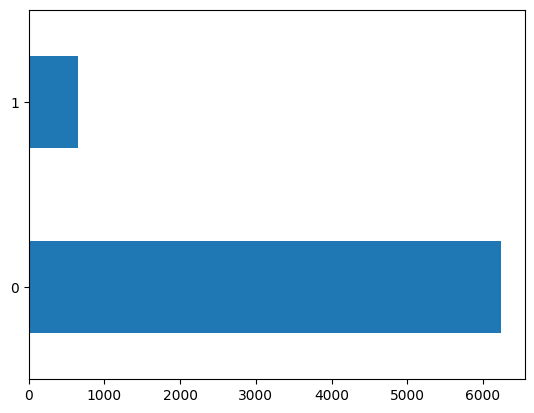

In [ ]:
print(df["response"].value_counts())
df["response"].value_counts().plot.barh()

We can clearly see that the daset is Imbalance. this can be fixed with SMOTE

In [ ]:
valid_df2.describe()

,tran_amount
count,124969.000000
mean,64.995143
std,22.860059
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


(<Figure size 600x600 with 1 Axes>, <Axes: >)

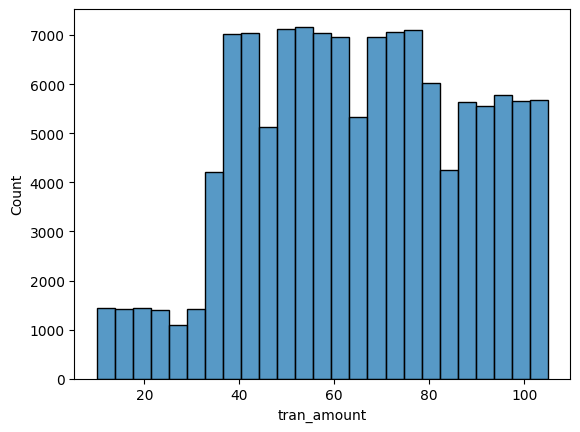

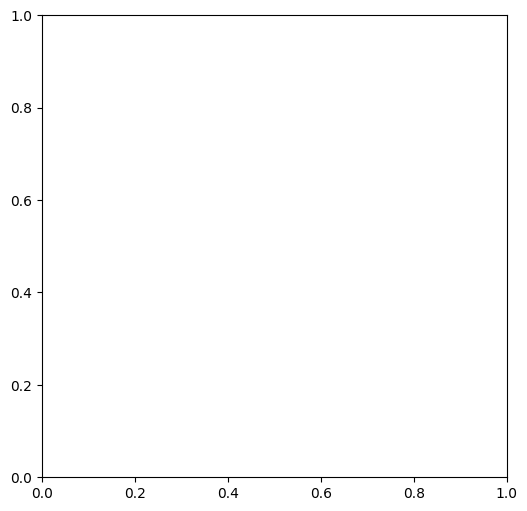

In [89]:
sns.histplot(data=valid_df2, x="tran_amount", bins=25)
plt.subplots(1,1, figsize=(6,6))


#Check datetimes

In [90]:
print(valid_df2.trans_date.min(),valid_df2.trans_date.max())

2011-05-16 00:00:00 2015-03-16 00:00:00


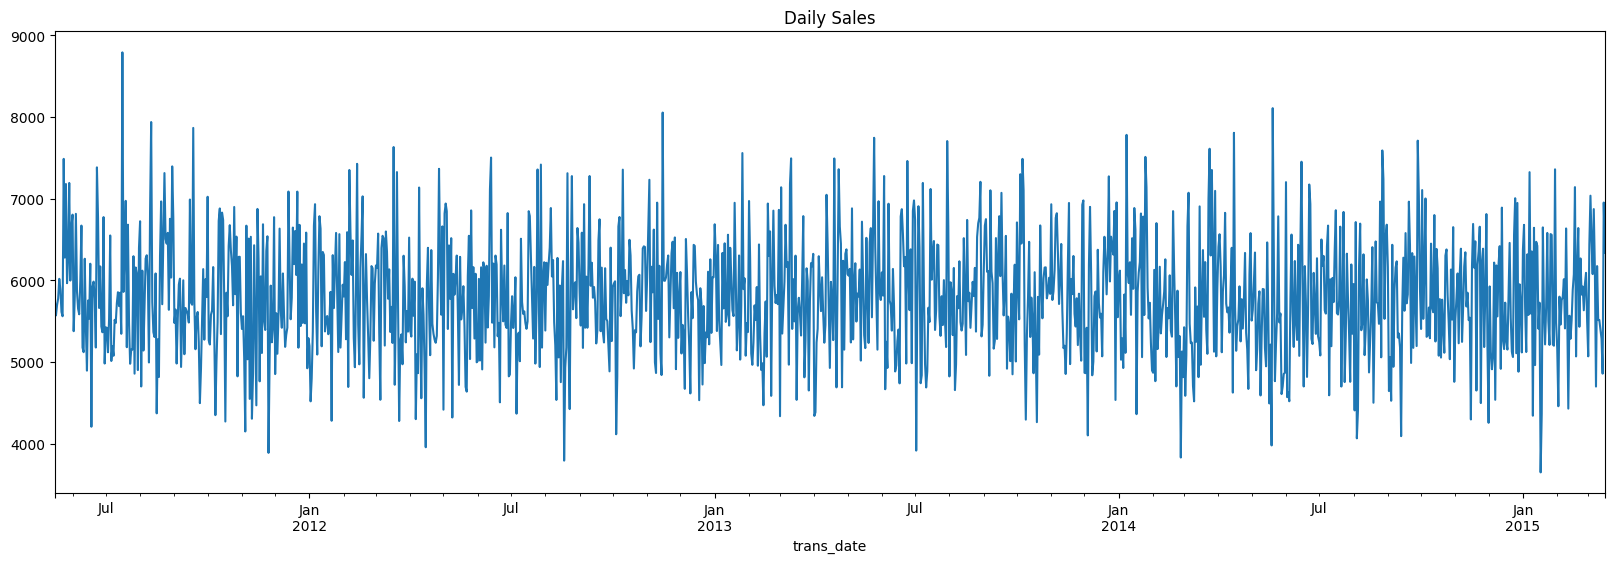

In [92]:
valid_df2.groupby('trans_date').tran_amount.sum().plot(title='Daily Sales', figsize=(20,6));

filter year 2013-2015

In [93]:
df3 = valid_df2.loc[valid_df2["trans_date"] >= "2013-12-31"]
print(df3.trans_date.min(),df3.trans_date.max())

2013-12-31 00:00:00 2015-03-16 00:00:00


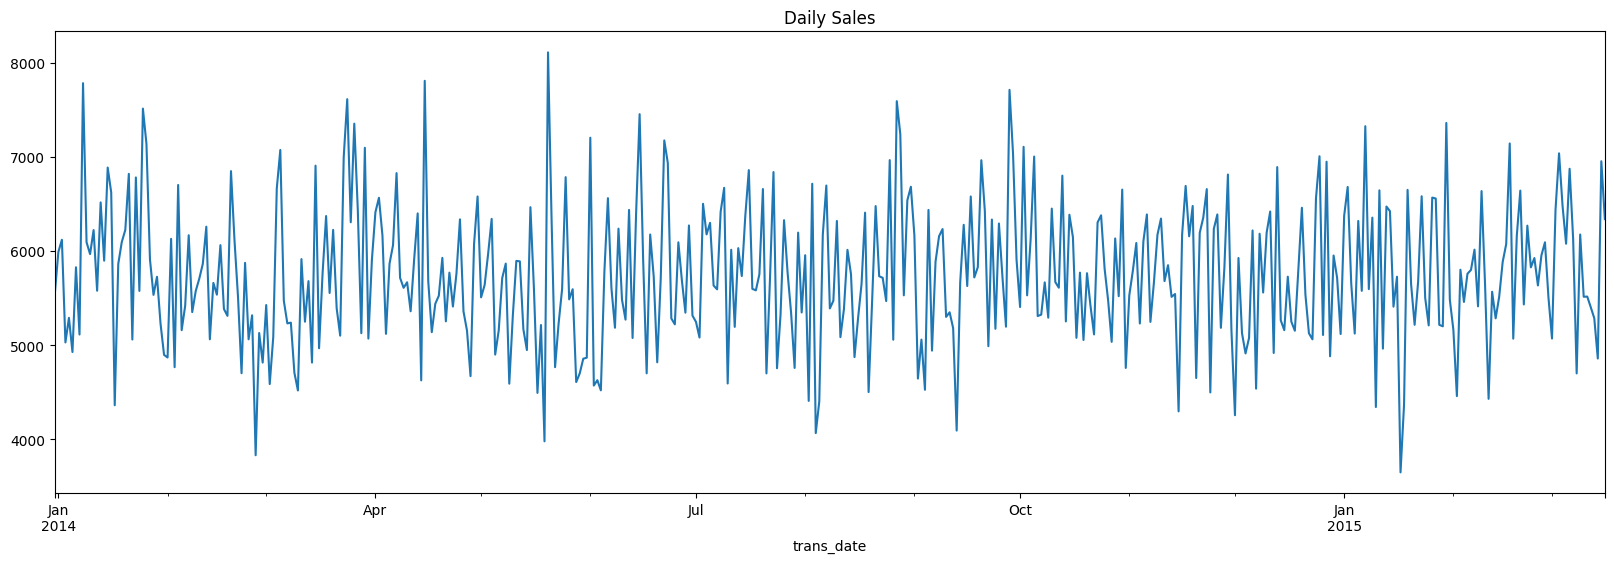

In [94]:
# Let's see how "daily sales" look like
df3.groupby('trans_date').tran_amount.sum().plot(title='Daily Sales', figsize=(20,6));

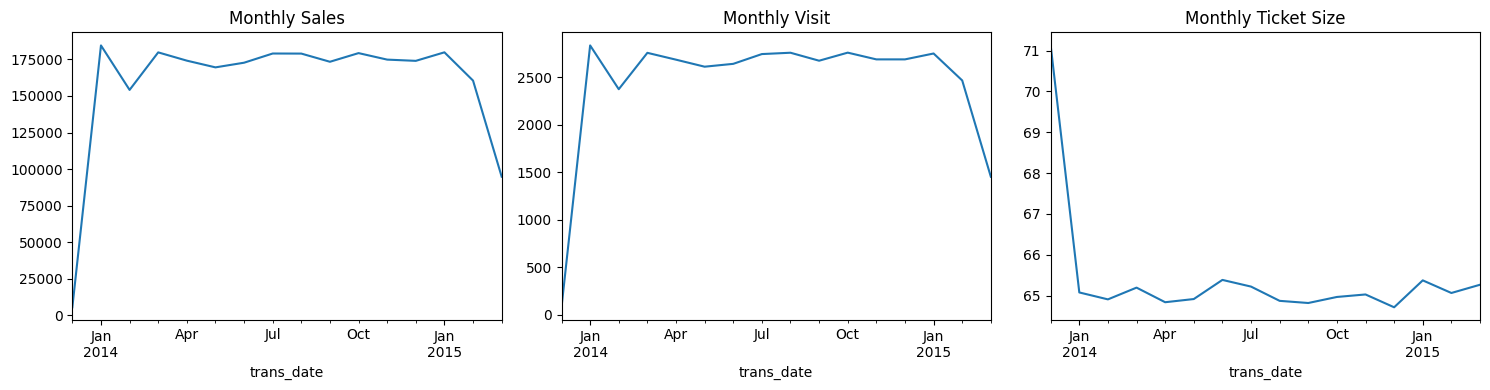

In [95]:
fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=True)

#sales by month --> group by sales month
df3.groupby(pd.Grouper(key='trans_date',freq='M')).tran_amount.sum().plot(title='Monthly Sales', ax=axes[0])
#visit by month = group by number of count trans_date
df3.groupby(pd.Grouper(key='trans_date',freq='M')).tran_amount.size().plot(title='Monthly Visit', ax=axes[1])
# ticket size = sales divided by visit
df3.groupby(pd.Grouper(key='trans_date',freq='M')).tran_amount.apply(lambda x: x.sum()/x.count()).plot(title='Monthly Ticket Size')
plt.show()

#Cohort Analysis

In [96]:
# Group transactions by customer_id and transaction "Month"
cohort = df3.groupby(['customer_id', pd.Grouper(key='trans_date', freq='M')], as_index=False).size()
# Rename trans_date to trans_month
cohort = cohort.rename(columns={'trans_date':'trans_month'})
cohort

,customer_id,trans_month,size
0,CS1112,2014-04-30,1
1,CS1112,2014-07-31,1
2,CS1112,2014-12-31,1
3,CS1112,2015-01-31,1
4,CS1113,2014-01-31,1
...,...,...,...
32265,CS9000,2014-01-31,1
32266,CS9000,2014-05-31,1
32267,CS9000,2014-07-31,1
32268,CS9000,2014-08-31,1


In [97]:
# Create a column to store start_month for each customer, we will use this in the later calculation
cohort['start_month'] = cohort.groupby('customer_id').trans_month.transform('min')

# Calculate the difference in months from start_month to trans_date.
cohort['month'] = cohort.apply(lambda x: (x.trans_month.year - x.start_month.year)*12 +
                               (x.trans_month.month - x.start_month.month) , axis=1)

cohort.head(10)

,customer_id,trans_month,size,start_month,month
0,CS1112,2014-04-30,1,2014-04-30,0
1,CS1112,2014-07-31,1,2014-04-30,3
2,CS1112,2014-12-31,1,2014-04-30,8
3,CS1112,2015-01-31,1,2014-04-30,9
4,CS1113,2014-01-31,1,2014-01-31,0
5,CS1113,2014-04-30,1,2014-01-31,3
6,CS1113,2014-05-31,1,2014-01-31,4
7,CS1113,2014-07-31,1,2014-01-31,6
8,CS1113,2015-01-31,1,2014-01-31,12
9,CS1113,2015-02-28,2,2014-01-31,13


In [98]:
cohort = pd.pivot_table(cohort, index='start_month', columns='month', values='customer_id', aggfunc='count').sort_index()
cohort.head()

month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
start_month,,,,,,,,,,,,,,,,
2013-12-31,78.0,28.0,23.0,22.0,22.0,27.0,23.0,23.0,23.0,23.0,27.0,26.0,27.0,26.0,20.0,20.0
2014-01-31,2306.0,669.0,791.0,774.0,778.0,750.0,734.0,721.0,738.0,738.0,716.0,741.0,734.0,696.0,438.0,NaN
2014-02-28,1315.0,424.0,405.0,387.0,429.0,446.0,464.0,432.0,429.0,421.0,399.0,424.0,375.0,255.0,NaN,NaN
2014-03-31,1017.0,333.0,313.0,321.0,332.0,330.0,324.0,348.0,336.0,335.0,342.0,325.0,187.0,NaN,NaN,NaN
2014-04-30,686.0,203.0,183.0,248.0,222.0,220.0,220.0,236.0,229.0,244.0,217.0,139.0,NaN,NaN,NaN,NaN


Column 0: is the starting month. <br>
Column N: is the n-th month from starting month.<br>
Let's look at the first cohort (2013-12-31). There are 78 customers made their first purchases in Dec 2013.<br>
Among the customers from this cohort, 28 customers made their purchases again in the next month.<br>
And there are 22 customers made the purchases 3 months after join. <br>
But raw counts are a bit difficult to interpret, seeing the percentage is way easier.
Instead, let's convert them into percentages.

In [99]:
# normalize number of customers for each month - dividing by # of cust in the starting month for each cohort
cohort = cohort.divide(cohort.iloc[:,0], axis=0).multiply(100)
# format the index
cohort.index = cohort.index.strftime('%Y-%m')
cohort.head()

month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
start_month,,,,,,,,,,,,,,,,
2013-12,100.0,35.897436,29.487179,28.205128,28.205128,34.615385,29.487179,29.487179,29.487179,29.487179,34.615385,33.333333,34.615385,33.333333,25.641026,25.641026
2014-01,100.0,29.011275,34.301821,33.564614,33.738075,32.523851,31.830009,31.266262,32.003469,32.003469,31.049436,32.133565,31.830009,30.182134,18.993929,NaN
2014-02,100.0,32.243346,30.798479,29.429658,32.623574,33.916350,35.285171,32.851711,32.623574,32.015209,30.342205,32.243346,28.517110,19.391635,NaN,NaN
2014-03,100.0,32.743363,30.776794,31.563422,32.645034,32.448378,31.858407,34.218289,33.038348,32.940020,33.628319,31.956735,18.387414,NaN,NaN,NaN
2014-04,100.0,29.591837,26.676385,36.151603,32.361516,32.069971,32.069971,34.402332,33.381924,35.568513,31.632653,20.262391,NaN,NaN,NaN,NaN


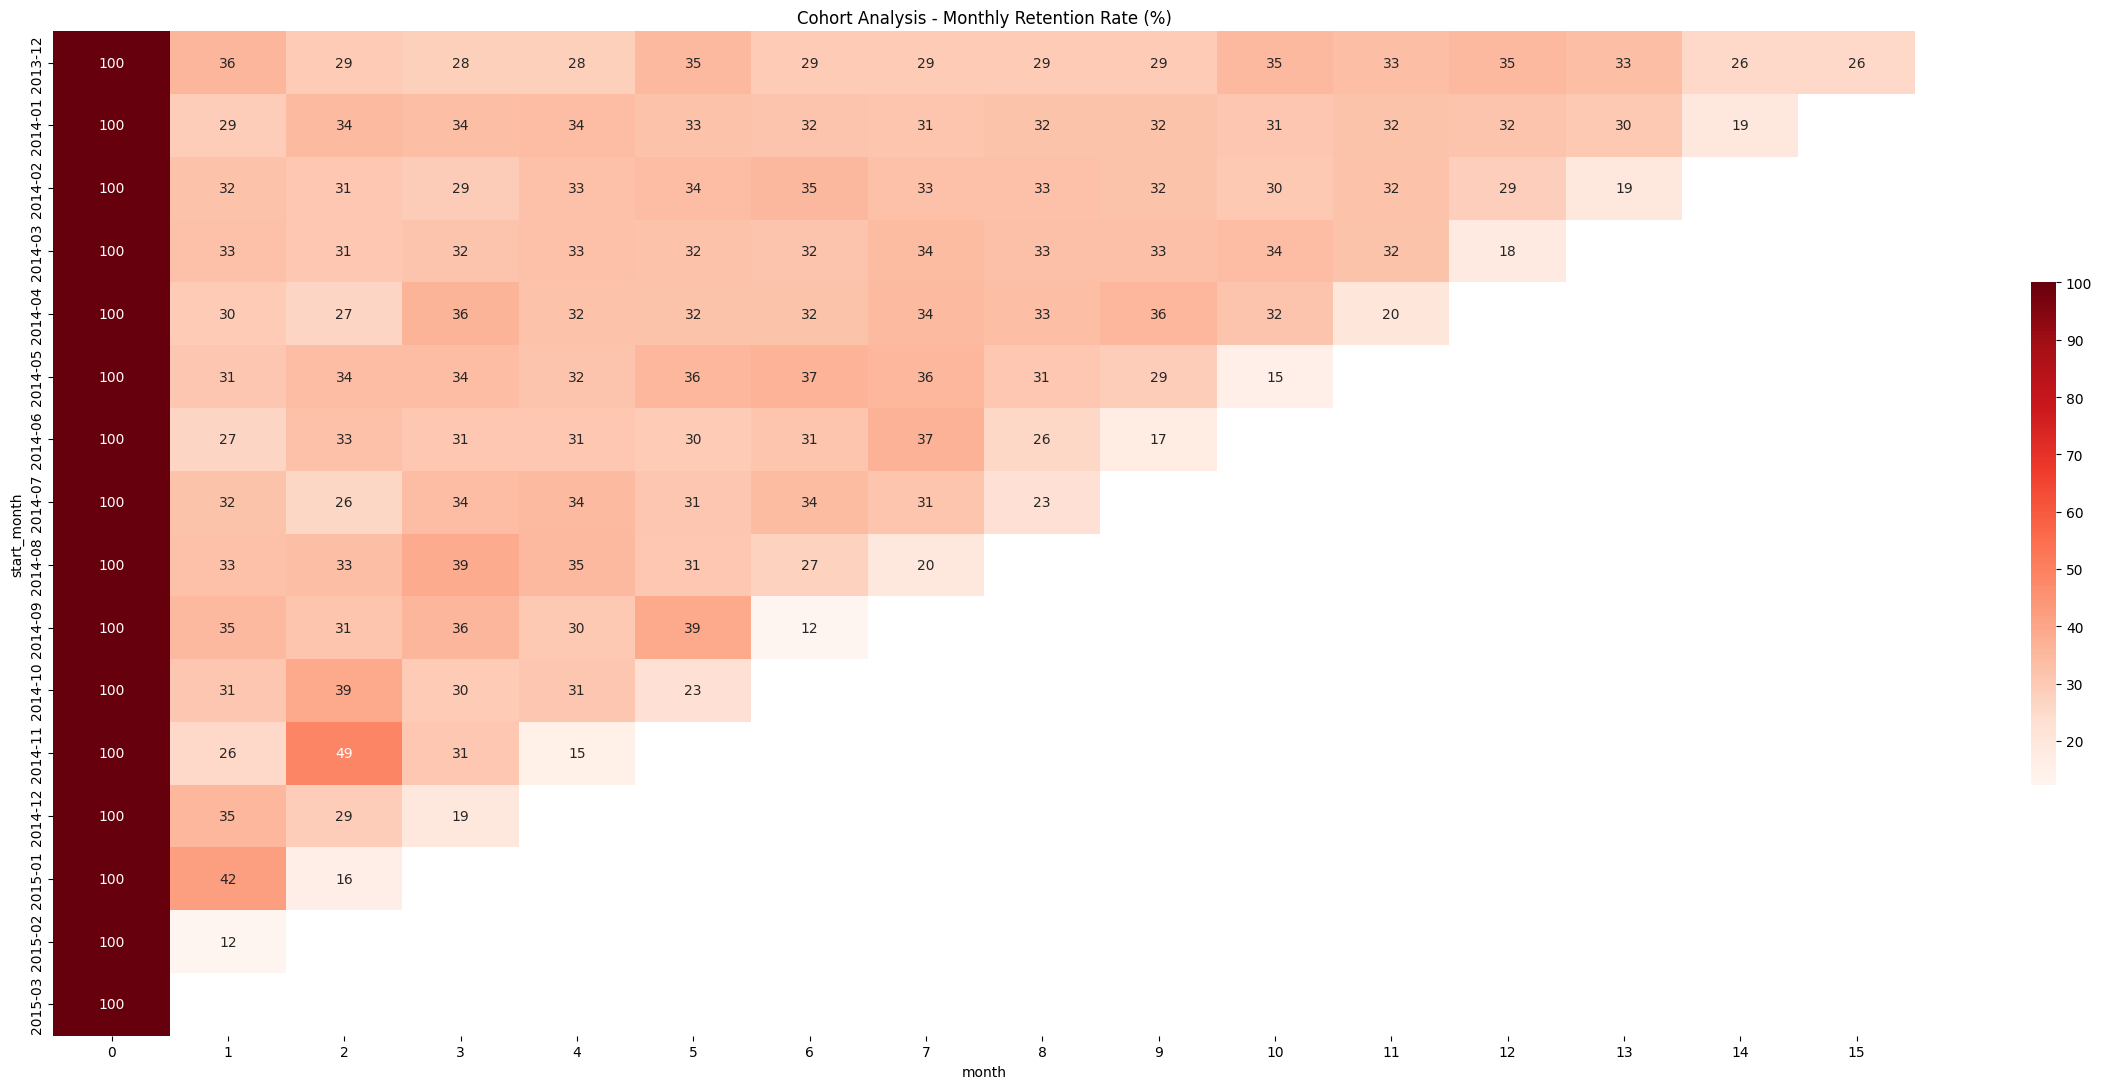

In [100]:
plt.figure(figsize=(24,11), dpi=100, tight_layout=True)
sns.heatmap(cohort, cmap='Reds', annot=True, fmt='.0f', cbar_kws={'shrink':.5})
plt.title('Cohort Analysis - Monthly Retention Rate (%)', fontsize=12);
# plt.savefig('cohort.png', bbox_inches="tight")